In [1]:
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

DATA_ROOT = Path.home() / "Library" / "CloudStorage" / "OneDrive-DanmarksTekniskeUniversitet" / "Virk2Vec" / "data"

### Setting up: Bankruptcy ground truth

In [2]:
# load data 
registration_folder = DATA_ROOT / "Tables" / "Registrations"
registration_files = [file for file in os.listdir(registration_folder) if file.endswith('.csv')]
registrations = pd.concat([pd.read_csv(os.path.join(registration_folder, file), index_col=0) for file in registration_files])

# filter status data
targets_all = ['UNDER KONKURS', "TVANGSOPLØST", "OPLØST EFTER KONKURS"]
registrations = registrations.loc[registrations.ChangeType == 'Status']
registrations = registrations.loc[registrations.NewValue.isin(targets_all)]

tvang_registrations = registrations.loc[registrations.NewValue.isin(["UNDER KONKURS"])][['CVR', 'FromDate', 'NewValue']]
u_konkurs_registrations = registrations.loc[registrations.NewValue.isin(["TVANGSOPLØST"])][['CVR', 'FromDate', 'NewValue']]

In [3]:
# assert no intersection between the two status types on CVR. 
intersect = set(tvang_registrations.CVR).intersection(set(u_konkurs_registrations.CVR))
df_bankrupt = pd.concat([tvang_registrations, u_konkurs_registrations]).sort_values('FromDate', ascending=True).drop_duplicates('CVR', keep='first')

# add the opløst efter konkurs
rest = registrations.loc[~registrations.CVR.isin(df_bankrupt.CVR)]
print(len(rest))
rest = rest.loc[rest.NewValue.isin(["OPLØST EFTER KONKURS"])]
print(len(rest))

df_bankrupt = pd.concat([df_bankrupt, rest[['CVR', 'FromDate', 'NewValue']]]).rename(columns={'FromDate': 'bankrupt_date', 'NewValue': 'bankrupt_type'})

21
21


### Setting up: Ownership data

In [4]:
folder = DATA_ROOT / "Tables" / "Participants"
files = [file for file in os.listdir(folder) if file.endswith('.csv')]
ownership_all = pd.concat([pd.read_csv(os.path.join(folder, file), index_col=0) for file in files])
ownership_all = ownership_all.loc[(ownership_all.RelationType == 'EJERANDEL') & (ownership_all.ParticipantType != 'PERSON')]

In [5]:
ownership_all['year'] = ownership_all.Date.str[:4].astype(int)
df_bankrupt['bankrupt_year'] = df_bankrupt.bankrupt_date.str[:4].astype(int)

### Viz 1:
- number of entries in the companies in the years up until the bankruptcy
- number of exits ----||-----

In [25]:
external = ownership_all.merge(df_bankrupt, on='CVR', how='left').fillna({'bankrupt_type': 'NOT BANKRUPT'})
external = external.groupby(['CVR','Participation', 'bankrupt_type']).count().reset_index()[['CVR','Participation', 'bankrupt_type', 'year']].rename(columns={'year':'count'})

internal = ownership_all.merge(df_bankrupt, left_on='EntityID', right_on='CVR', how='left').fillna({'bankrupt_type': 'NOT BANKRUPT'})
internal = internal.groupby(['EntityID','Participation', 'bankrupt_type']).count().reset_index()[['EntityID','Participation', 'bankrupt_type', 'year']].rename(columns={'year':'count'})

<AxesSubplot: xlabel='bankrupt_type', ylabel='count'>

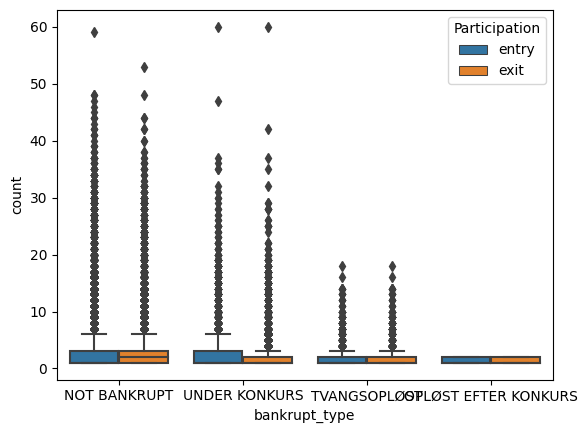

In [26]:
sns.boxplot(x='bankrupt_type', y='count',hue='Participation', data=external)

<AxesSubplot: xlabel='bankrupt_type', ylabel='count'>

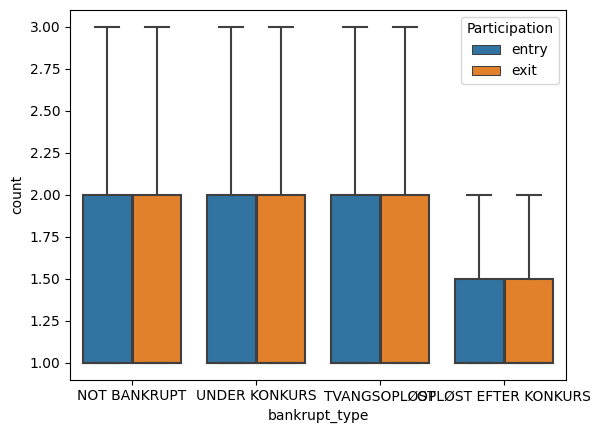

In [28]:
sns.boxplot(x='bankrupt_type', y='count',hue='Participation', data=internal, showfliers=False)

In [11]:
ownership_all

,CVR,EntityID,Name,ParticipantType,RelationType,Participation,Date,EquityPct,year
16,34083150,33393539,ALEYNA HOLDING ApS,VIRKSOMHED,EJERANDEL,entry,2011-12-15,1.00,2011
17,34083150,33393539,ALEYNA HOLDING ApS,VIRKSOMHED,EJERANDEL,exit,2019-05-31,1.00,2019
120,16989533,28860293,"J.Ø. HOLDING, SUNDSØRE ApS",VIRKSOMHED,EJERANDEL,entry,2005-06-29,1.00,2005
121,16989533,28860293,"J.Ø. HOLDING, SUNDSØRE ApS",VIRKSOMHED,EJERANDEL,exit,2021-11-21,1.00,2021
174,71088928,37747742,PLK Invest IVS,VIRKSOMHED,EJERANDEL,entry,2016-05-27,0.05,2016
...,...,...,...,...,...,...,...,...,...
111943,41732598,4008653474,Henrik Engsner AB,ANDEN_DELTAGER,EJERANDEL,entry,2020-12-14,0.05,2020
111944,41732598,4008653474,Henrik Engsner AB,ANDEN_DELTAGER,EJERANDEL,exit,2021-07-22,0.05,2021
111945,41732598,41893788,SK PE ApS,VIRKSOMHED,EJERANDEL,entry,2021-01-25,0.05,2021
111946,41732598,41893788,SK PE ApS,VIRKSOMHED,EJERANDEL,exit,2021-03-22,0.05,2021
